In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import keras
import os 
from PIL import Image
import cv2 as cv 

In [2]:
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.preprocessing import image
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [3]:
np.random.seed(42)

In [4]:
cat_train = '/kaggle/input/cat-and-dog/training_set/training_set/cats/'

cat_test = '/kaggle/input/cat-and-dog/test_set/test_set/cats/'

dog_train = '/kaggle/input/cat-and-dog/training_set/training_set/dogs/'

dog_test = '/kaggle/input/cat-and-dog/test_set/test_set/dogs/'


train_data = '/kaggle/input/cat-and-dog/training_set/training_set/'
test_data = '/kaggle/input/cat-and-dog/test_set/test_set/'

In [5]:
print("Total cats for training = ", len(os.listdir(cat_train)))
print("Total cats for testing = ", len(os.listdir(cat_test)))
print("Total dogs for training = ", len(os.listdir(dog_train)))
print("Total dogs for testing = ", len(os.listdir(dog_test)))


Total cats for training =  4001
Total cats for testing =  1012
Total dogs for training =  4006
Total dogs for testing =  1013


# Set pre-trained model weights and input shape

In [6]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in resnet.layers:
    layer.trainable = False,

94765736/94765736 [==============================] - 0s 0us/step


## Converting image to executable data using ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [8]:
target = (224,224)
batch = 32
epochs = 5

## Train, Validation and Test Data

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory=train_data,
    target_size=target,
    batch_size=batch,
    class_mode='binary',
    subset='training'
)


validation_generator = train_datagen.flow_from_directory(
    directory=train_data,
    target_size=target,
    batch_size=batch,
    class_mode='binary',
    subset='validation'
)



test_generator = test_datagen.flow_from_directory(
    directory=test_data,
    target_size=target,
    batch_size=batch,
    class_mode='binary'
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


# Adding ResNet to custom model with custom output

In [10]:
x = resnet.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=resnet.input, outputs=predictions)

In [11]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/5
201/201 [==============================] - 192s 787ms/step - loss: 0.1907 - accuracy: 0.9218 - val_loss: 4.2212 - val_accuracy: 0.4997
Epoch 2/5
201/201 [==============================] - 103s 511ms/step - loss: 0.0886 - accuracy: 0.9672 - val_loss: 0.7235 - val_accuracy: 0.5765
Epoch 3/5
201/201 [==============================] - 103s 509ms/step - loss: 0.0726 - accuracy: 0.9758 - val_loss: 0.6164 - val_accuracy: 0.7027
Epoch 4/5
201/201 [==============================] - 103s 511ms/step - loss: 0.0609 - accuracy: 0.9799 - val_loss: 0.5678 - val_accuracy: 0.8682
Epoch 5/5
201/201 [==============================] - 101s 504ms/step - loss: 0.0704 - accuracy: 0.9791 - val_loss: 1.8939 - val_accuracy: 0.7833


### Train Validation Plot

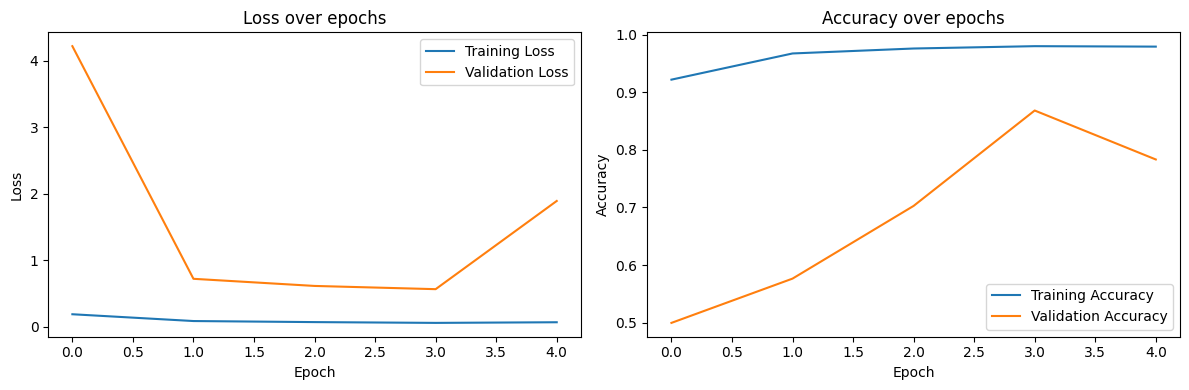

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Evaluating on unseen data

In [14]:
loss, accuracy = model.evaluate(test_generator)
print("Test Evaluation")
print(f"Loss:{loss}\nAccuracy:{accuracy}")

64/64 [==============================] - 18s 286ms/step - loss: 1.3542 - accuracy: 0.8621
Test Evaluation
Loss:1.3541876077651978
Accuracy:0.8620859980583191


1/1 [==============================] - 0s 23ms/step
[[0.99998903]]
dog


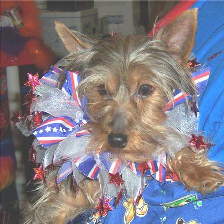

In [21]:
img1 = image.load_img('/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4097.jpg', target_size=(224, 224))
img_array1 = image.img_to_array(img1)
img_array1 = np.expand_dims(img_array1, axis=0) / 255.0  # Normalize the image
pred = model.predict(img_array1)
print(pred)
print("cat" if pred[0] < 0.5 else "dog")
img1


1/1 [==============================] - 0s 30ms/step
cat


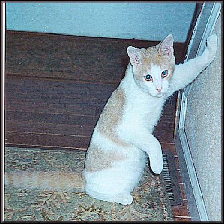

In [19]:
img = image.load_img('/kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4001.jpg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
pred = model.predict(img_array)
print("cat" if pred < 0.5 else "dog")
img


### Predicting on new dataset

1/1 [==============================] - 0s 21ms/step


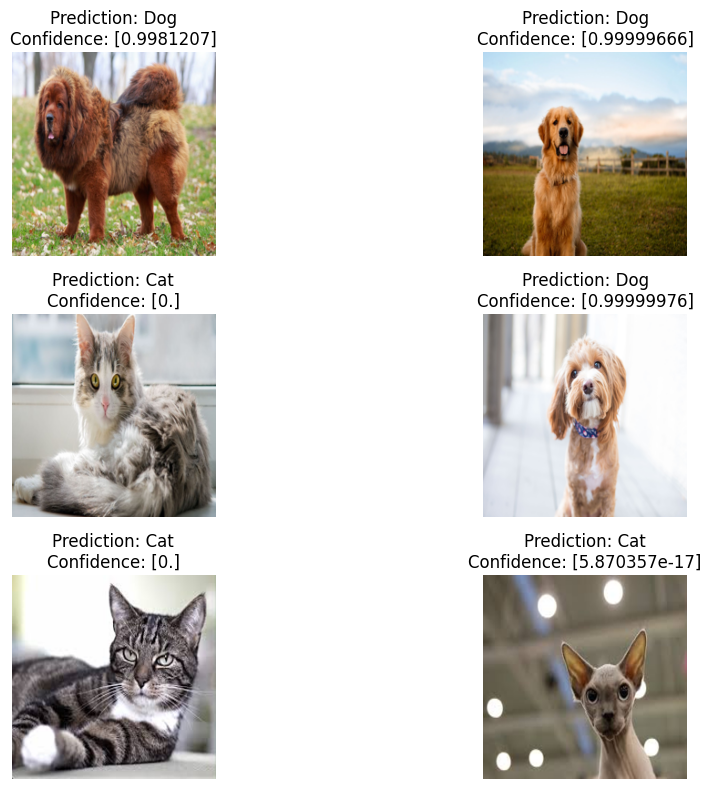

In [24]:
test_images_dir = "/kaggle/input/catdog/"
test_files = [file for file in os.listdir(test_images_dir) if file.endswith('.jpg')]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))

for i, image_path in enumerate(test_files):
    # Load and preprocess the image
    img = Image.open(os.path.join(test_images_dir, image_path))
    img = img.resize((224, 224))  # Resize the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

    # Make predictions
    evaluation = model.evaluate(img_array)
    predictions = model.predict(img_array)
    
    # Determine class label
    class_label = "Cat" if predictions[0] < 0.5 else "Dog"

    # Plot the image
    row = i // 2
    col = i % 2
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Prediction: {class_label}\nConfidence: {predictions[0]}")

plt.tight_layout()
plt.show()

##### Model Summary

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          